In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler, minmax_scale

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
X = np.array([
    [5.8, 5.9, 5.8, 5.7, 5.8, 5.9, 5.7, 5.5, 5.8, 5.8, 5.7, 5.8],
    [5.6, 5.8, 5.7, 5.6, 5.7, 5.9, 5.6, 5.5, 5.7, 5.6, 5.5, 5.9],
    [5.9, 5.8, 5.8, 5.8, 5.7, 5.8, 5.4, 5.0, 5.9, 5.9, 5.8, 5.8],
    [6.0, 6.0, 5.8, 5.7, 5.8, 5.9, 5.9, 5.9, 5.7, 5.9, 5.6, 5.7],
    [5.9, 6.0, 5.8, 5.9, 5.8, 5.8, 5.9, 5.6, 5.9, 5.9, 5.9, 5.9],
    [5.8, 5.9, 5.6, 5.9, 6.0, 5.9, 5.8, 5.8, 5.6, 5.9, 5.9, 5.8],
    [6.0, 6.0, 6.0, 5.7, 6.0, 5.9, 5.9, 5.7, 6.0, 5.9, 5.9, 6.0],
    [5.5, 5.8, 5.8, 5.8, 5.9, 5.8, 5.9, 5.7, 5.9, 6.0, 5.9, 5.9],
    [5.3, 5.4, 5.8, 5.8, 5.5, 5.4, 5.9, 5.7, 5.7, 5.9, 5.8, 5.6],
    [4.6, 5.5, 5.8, 5.6, 5.5, 5.4, 5.9, 5.5, 5.5, 5.9, 5.9, 5.3],
], dtype=float)

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_recon = pca.inverse_transform(X_pca)
pca_error = np.mean((X_scaled - X_recon) ** 2, axis=1)

iso = IsolationForest(contamination=0.2)
iso_scores = minmax_scale(-iso.fit(X_scaled).score_samples(X_scaled))

ocsvm = OneClassSVM(kernel='rbf', nu=0.2, gamma='scale')
ocsvm_scores = minmax_scale(-ocsvm.fit(X_scaled).decision_function(X_scaled))

elliptic = EllipticEnvelope(contamination=0.2, support_fraction=0.8)
elliptic_scores = minmax_scale(-elliptic.fit(X_scaled).score_samples(X_scaled))

lof = LocalOutlierFactor(n_neighbors=5, contamination=0.2, novelty=True)
lof.fit(X_scaled)
lof_scores = minmax_scale(-lof.decision_function(X_scaled))

In [7]:
score_table = pd.DataFrame(
    {
        'pca_reconstruction': minmax_scale(pca_error),
        'isolation_forest': iso_scores,
        'one_class_svm': ocsvm_scores,
        'elliptic_envelope': elliptic_scores,
        'local_outlier_factor': lof_scores,
    }
)

In [8]:
score_table['ensemble_score'] = score_table.mean(axis=1)
ensemble_threshold = score_table['ensemble_score'].quantile(0.75)
score_table['is_anomaly'] = score_table['ensemble_score'] >= ensemble_threshold

In [9]:
anomalies = score_table.index[score_table['is_anomaly']].tolist()
score_table_sorted = score_table.sort_values('ensemble_score', ascending=False)
score_table_sorted

,pca_reconstruction,isolation_forest,one_class_svm,elliptic_envelope,local_outlier_factor,ensemble_score,is_anomaly
9,0.063134,1.000000,0.997144,1.804112e-16,1.000000,0.612056,True
6,0.195719,0.348912,0.993419,1.000000e+00,0.097308,0.527072,True
4,1.000000,0.000000,0.997905,2.559834e-01,0.230623,0.496902,True
7,0.875860,0.206243,0.997378,1.804112e-16,0.230623,0.462021,False
8,0.125665,0.573103,1.000000,9.714451e-17,0.455290,0.430812,False
1,0.000000,0.585770,0.997905,5.134781e-16,0.488130,0.414361,False
2,0.021462,0.455950,0.994472,1.387779e-16,0.308210,0.356019,False
5,0.119685,0.418703,0.996962,0.000000e+00,0.129600,0.332990,False
3,0.015211,0.133507,0.997816,1.110223e-16,0.049385,0.239184,False
0,0.027729,0.056782,0.000000,5.967449e-16,0.000000,0.016902,False


In [10]:
print('Аномалии:')
for label in score_table_sorted.index[score_table_sorted['is_anomaly']]:
    print(f" - {label}: score={score_table.loc[label, 'ensemble_score']:.3f}")

Аномалии:
 - 9: score=0.612
 - 6: score=0.527
 - 4: score=0.497


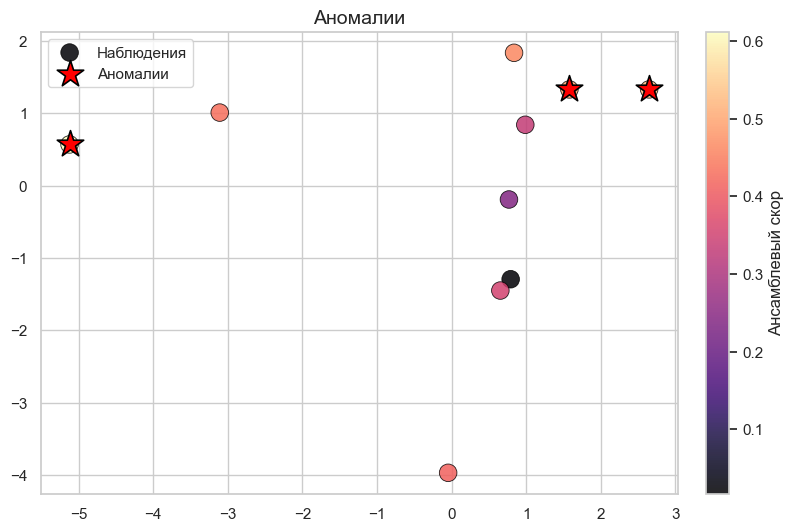

In [11]:
scores_for_plot = score_table.loc[range(10), 'ensemble_score']

fig, ax = plt.subplots(figsize=(9, 6))
points = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=scores_for_plot,
                    cmap='magma', s=160, edgecolor='black', linewidth=0.6, 
                    alpha=0.85, label='Наблюдения'
                    )

if anomalies:
    ax.scatter(X_pca[anomalies, 0], X_pca[anomalies, 1], c='red',
               s=400, marker='*', edgecolor='black', linewidth=1.2, label='Аномалии'
               )

ax.set_title('Аномалии', fontsize=14)
ax.legend(loc='upper left')
fig.colorbar(points, ax=ax, fraction=0.046, pad=0.04, label='Ансамблевый скор')
plt.show()


In [12]:
import anomaly_visualization

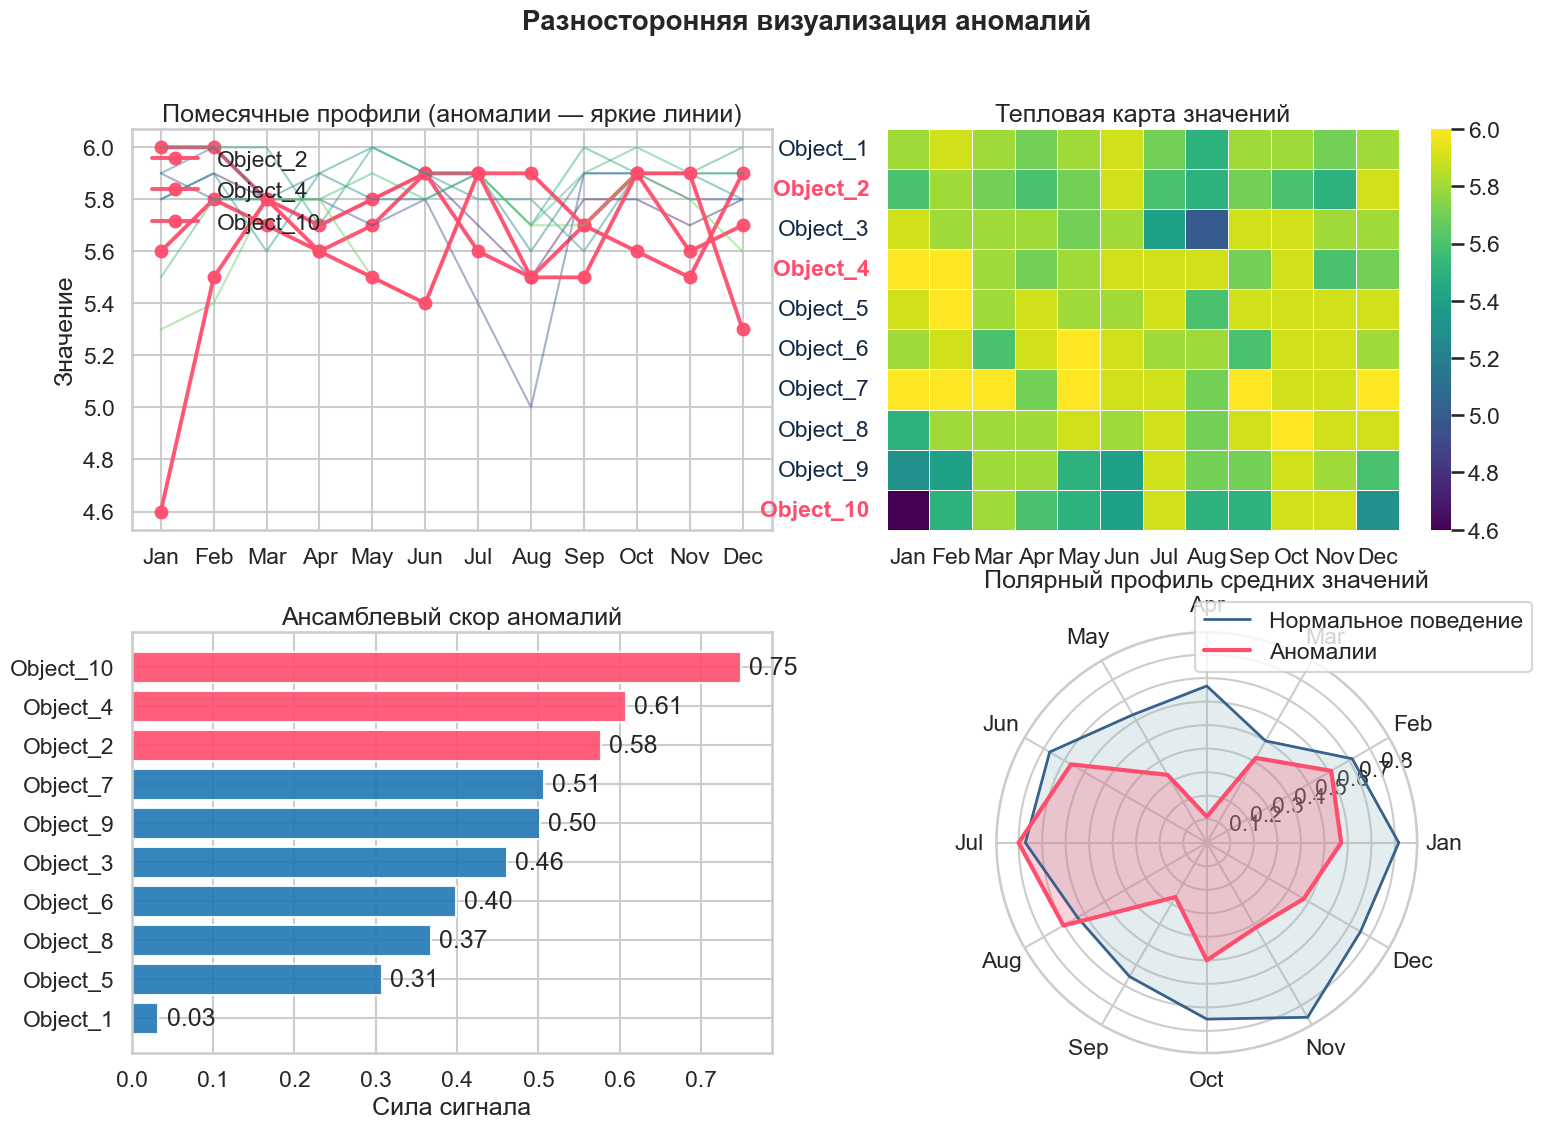

In [13]:
anomaly_visualization.main()

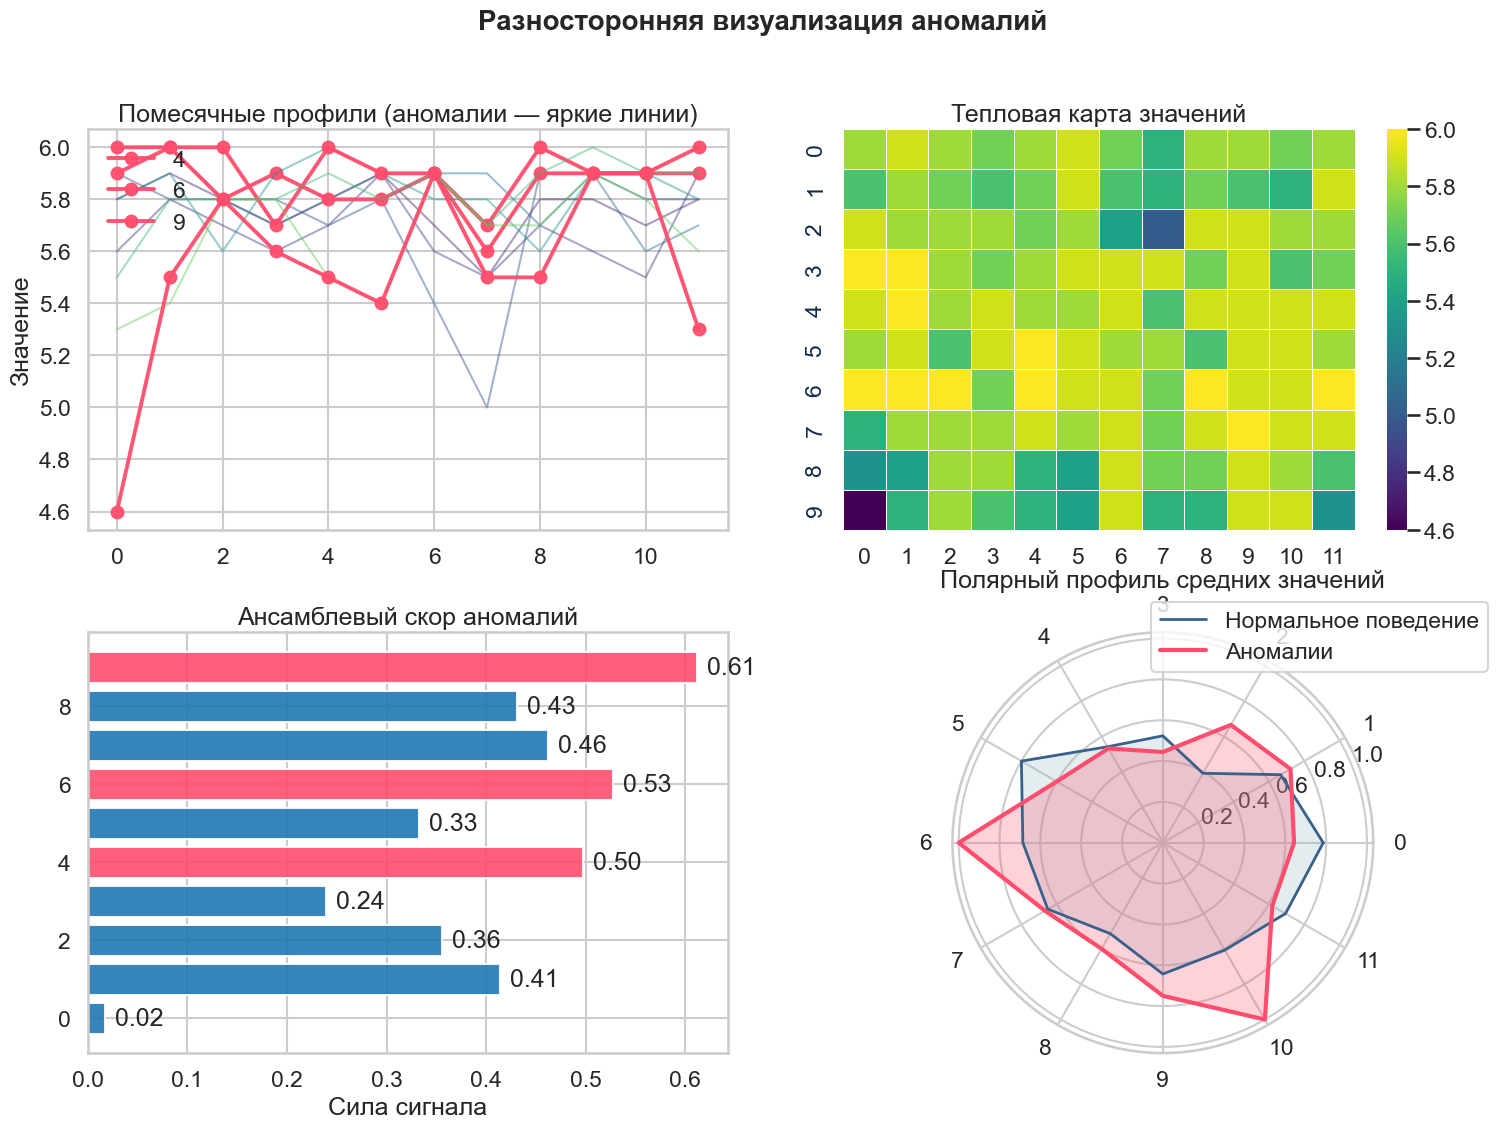

In [15]:
import anomaly_visualization as av
df = pd.DataFrame(X)
_ = av.render_dashboard(df=df, score_table=score_table, anomalies=anomalies)